In [1]:
import os
os.chdir('../../')
import warnings
warnings.filterwarnings('ignore')
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import loompy as lp
import matplotlib.pyplot as plt
from collections import Counter

from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss

from adjustText import adjust_text

In [9]:
adata = sc.read_h5ad('tmp/pyscenic/seacell.h5ad')
adata.X = adata.layers['raw'].copy()
adata

AnnData object with n_obs × n_vars = 15247 × 29437
    obs: 'tumor', 'tumor_purity', 'ncells_per_SEACell', 'author', 'donor_id', 'method', 'assay'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'raw'

# 0. Main

In [86]:
paths = [os.path.join('tmp/pyscenic', f, 'scenic_out.loom') for f in os.listdir('tmp/pyscenic') if os.path.isdir(os.path.join('tmp/pyscenic', f))]
paths

['tmp/pyscenic/iteration_51/scenic_out.loom',
 'tmp/pyscenic/iteration_52/scenic_out.loom',
 'tmp/pyscenic/iteration_53/scenic_out.loom',
 'tmp/pyscenic/iteration_54/scenic_out.loom',
 'tmp/pyscenic/iteration_55/scenic_out.loom',
 'tmp/pyscenic/iteration_56/scenic_out.loom',
 'tmp/pyscenic/iteration_57/scenic_out.loom',
 'tmp/pyscenic/iteration_58/scenic_out.loom',
 'tmp/pyscenic/iteration_59/scenic_out.loom',
 'tmp/pyscenic/iteration_60/scenic_out.loom',
 'tmp/pyscenic/iteration_61/scenic_out.loom',
 'tmp/pyscenic/iteration_62/scenic_out.loom',
 'tmp/pyscenic/iteration_1/scenic_out.loom']

In [88]:
def calculate_rss(path):
    with lp.connect(path, mode="r+", validate=False) as lf:
        auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
        rss = regulon_specificity_scores(auc_mtx, adata.obs.tumor)
        rss.columns = [f.replace("(+)", "") for f in list(rss.columns)]
    return rss

all_rss = []
all_columns = []

for path in paths:
    try:
        rss = calculate_rss(path)
        all_rss.append(rss.T)
        all_columns.extend(rss.columns.tolist())
    except Exception as e:
        print(f"Error reading iteration {path}: {e}")

Error reading iteration tmp/pyscenic/iteration_1/scenic_out.loom: File 'tmp/pyscenic/iteration_1/scenic_out.loom' not found


In [92]:
column_freq = pd.DataFrame.from_dict(
    Counter(all_columns), 
    orient='index', 
    columns=['frequency']
).sort_values('frequency', ascending=False)

reliable_tf = column_freq[column_freq.frequency > 0.5 * 12].index.tolist()

In [98]:
concat_rss = pd.concat(all_rss, axis=1)
final_rss = concat_rss.groupby(level=0, axis=1).mean()
rss = final_rss.loc[reliable_tf, :]

In [104]:
rss.sort_values('tumor', ascending = False).head(30).index

Index(['SOX4', 'TEAD4', 'HOXC9', 'FOSL1', 'ERG', 'HOXD13', 'MNX1', 'EBF1',
       'SOX5', 'FOXF1', 'HOXC10', 'E2F1', 'SOX6', 'FOSL2', 'SMAD5', 'ETS1',
       'RELB', 'IRF3', 'ZNF148', 'NFKB2', 'NFKB1', 'ATF4', 'RARG', 'KLF12',
       'E2F2', 'IRF1', 'BCLAF1', 'ELK1', 'CEBPG', 'MYBL1'],
      dtype='object')

# old

In [67]:
i = 51
adj = pd.read_csv(f'tmp/pyscenic/iteration_{i}/adj.csv')

regulons = {}
with lp.connect(f'tmp/pyscenic/iteration_{i}/scenic_out.loom', mode="r+", validate=False) as lf:
    auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
    exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
    regulon_df = pd.DataFrame(lf.ra.Regulons, index=lf.ra.Gene)
    for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).items():
        regulons[i] =  list(r[r==1].index.values)
        
rss = regulon_specificity_scores(auc_mtx.iloc[:,:-1], adata.obs.tumor)
rss.columns = [f.replace("(+)", "") for f in list(rss.columns)]

In [70]:
rss = regulon_specificity_scores(auc_mtx, adata.obs.tumor)

In [66]:
rss.T.sort_values('tumor', ascending = False).head(20)

,tumor,normal
SOX4,0.457732,0.417530
HOXC9,0.429025,0.273079
TEAD4,0.428859,0.390108
EBF1,0.422062,0.444814
FOSL1,0.421786,0.507381
SOX11,0.408035,0.375703
ERG,0.377993,0.464642
SOX5,0.376487,0.433920
HOXC10,0.375916,0.228817
POU3F2,0.371528,0.343341


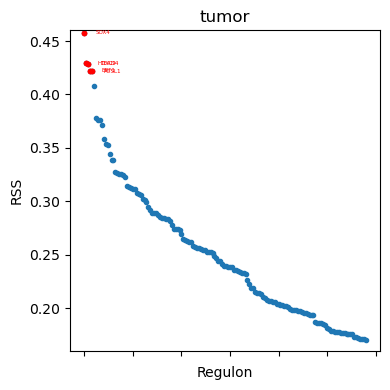

In [65]:
plot_rss(rss, 'tumor', top_n=5)

# 1. Filter

In [4]:
top_regulons = rss.T.sort_values("tumor", ascending=False).head(100).index

threshold = adj.importance.quantile(0.80)
output = adj[adj.TF.isin(top_regulons) & (adj.importance>threshold)].sort_values("importance", ascending=False)

In [ ]:
# output.to_csv(f"tmp/pyscenic/top_regulons.csv", index=False)

# 2. Visualize

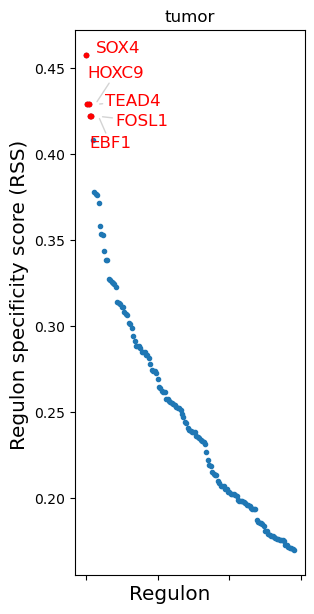

In [5]:
cats = list(adata.obs.tumor.unique())

# Plot for the first category only
c = cats[0]
fig = plt.figure(figsize=(3, 6))

x = rss.T[c]
ax = fig.add_subplot(1, 1, 1)  # Only one subplot
plot_rss(rss, c, top_n=5, max_n=None, ax=ax)
ax.set_ylim(x.min() - (x.max() - x.min()) * 0.05, x.max() + (x.max() - x.min()) * 0.05)

for t in ax.texts:
    t.set_fontsize(12)
ax.set_ylabel('')
ax.set_xlabel('')
adjust_text(ax.texts, arrowprops=dict(arrowstyle='-', color='lightgrey'))

fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
    'figure.titlesize': 'large',
    'axes.labelsize': 'medium',
    'axes.titlesize': 'large',
    'xtick.labelsize': 'medium',
    'ytick.labelsize': 'medium'
})

plt.show()

In [6]:
# sc.pl.matrixplot(adata_top_tfs, tf_names, groupby="tumor", cmap="viridis", dendrogram=True, figsize=[15, 5.5], standard_scale="group",)

In [30]:
# sns.clustermap(mean_auc_by_cell_type_top_n, xticklabels=True, yticklabels=True, cmap = 'viridis', figsize = (20, 12))

# 3. Analyze

In [29]:
clean_data = adata[adata.obs.tumor_purity > 0.8].copy()

merged_df = pd.concat([clean_data.obs, auc_mtx], axis=1)
tumor_cols = [col for col in merged_df.columns if col.endswith("(+)")]
filtered_df = merged_df.dropna(subset=['tumor'])[tumor_cols + ['tumor']]

result = filtered_df.groupby('tumor').mean().T
result['ratio'] = result['tumor'] / result['normal']
top_ratios = result.nlargest(30, 'ratio')

In [31]:
top_ratios

tumor,normal,tumor,ratio
HOXC10(+),0.005331,0.025226,4.731865
HOXA11(+),0.008053,0.035613,4.422167
POU2F1(+),0.000582,0.002286,3.927679
HOXA6(+),0.009396,0.033126,3.525468
HOXD13(+),0.009177,0.030533,3.326985
HOXC9(+),0.007479,0.024027,3.212676
RNF114(+),0.000111,0.000302,2.734442
HOXA3(+),0.006434,0.014364,2.232583
ZNF160(+),0.006657,0.012942,1.944176
RAD21(+),0.002828,0.005323,1.882385


In [58]:
regulon_df

,AKR1A1(+),ARID3A(+),ARNT(+),ATF3(+),ATF4(+),ATF6(+),BANP(+),BCL3(+),BCLAF1(+),BHLHE40(+),...,ZNF407(+),ZNF573(+),ZNF584(+),ZNF594(+),ZNF611(+),ZNF649(+),ZNF76(+),ZNF766(+),ZNF789(+),ZNF91(+)
7SK.4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG-AS1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2M,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZYG11B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZYX,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZZEF1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 4. Merge AucMTX

In [43]:
all_auc_mtx = []
all_columns = []

for i in range(1, 101):
    try:
        with lp.connect(f'tmp/pyscenic/iteration_{i}/scenic_out.loom', mode='r+', validate=False) as lf:
            auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
            all_auc_mtx.append(auc_mtx)
            all_columns.extend(auc_mtx.columns.tolist())
    except Exception as e:
        print(f"Error reading iteration {i}: {e}")

Error reading iteration 1: File 'tmp/pyscenic/iteration_1/scenic_out.loom' not found
Error reading iteration 2: File 'tmp/pyscenic/iteration_2/scenic_out.loom' not found
Error reading iteration 3: File 'tmp/pyscenic/iteration_3/scenic_out.loom' not found
Error reading iteration 4: File 'tmp/pyscenic/iteration_4/scenic_out.loom' not found
Error reading iteration 5: File 'tmp/pyscenic/iteration_5/scenic_out.loom' not found
Error reading iteration 6: File 'tmp/pyscenic/iteration_6/scenic_out.loom' not found
Error reading iteration 7: File 'tmp/pyscenic/iteration_7/scenic_out.loom' not found
Error reading iteration 8: File 'tmp/pyscenic/iteration_8/scenic_out.loom' not found
Error reading iteration 9: File 'tmp/pyscenic/iteration_9/scenic_out.loom' not found
Error reading iteration 10: File 'tmp/pyscenic/iteration_10/scenic_out.loom' not found
Error reading iteration 11: File 'tmp/pyscenic/iteration_11/scenic_out.loom' not found
Error reading iteration 12: File 'tmp/pyscenic/iteration_12/s

In [51]:
column_freq = pd.DataFrame.from_dict(
    Counter(all_columns), 
    orient='index', 
    columns=['frequency']
).sort_values('frequency', ascending=False)

reliable_tf = column_freq[column_freq.frequency > 0.5 * 12].index.tolist()

In [45]:
concat_auc_mtx = pd.concat(all_auc_mtx, axis=1)
final_auc_mtx = concat_auc_mtx.groupby(level=0, axis=1).mean()
auc_mtx = final_auc_mtx.loc[:,reliable_tf]

In [56]:
clean_data = adata[adata.obs.tumor_purity > 0.8].copy()

merged_df = pd.concat([clean_data.obs, auc_mtx], axis=1)
tumor_cols = [col for col in merged_df.columns if col.endswith("(+)")]
filtered_df = merged_df.dropna(subset=['tumor'])[tumor_cols + ['tumor']]

result = filtered_df.groupby('tumor').mean().T
result['ratio'] = result['tumor'] / result['normal']
top_ratios = result.nlargest(30, 'ratio')

In [57]:
top_ratios

tumor,normal,tumor,ratio
HOXD13(+),0.007162,0.031139,4.347868
HOXC9(+),0.006858,0.023981,3.496693
HOXC10(+),0.006519,0.022617,3.469310
POU2F1(+),0.000500,0.001093,2.188067
MNX1(+),0.008117,0.017612,2.169911
RAD21(+),0.002038,0.004365,2.141530
CEBPG(+),0.006175,0.010761,1.742654
NFYB(+),0.000155,0.000250,1.617662
FOXF1(+),0.013052,0.020604,1.578606
SOX4(+),0.005511,0.008137,1.476497
